<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/notes/01_notes_FastMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes on MRI -> k space -> image

# Setup

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Set path to proj
PROJ       = "fastmri"

ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
GDRIVE_PATH   = ALL_PROJ_PATH/PROJ                  # path to project on GDrive
GDRIVE_PATH.mkdir(parents=True, exist_ok=True) # make dir in Gdrive to house Github

%cd "$GDRIVE_PATH"

Path.BASE_PATH = GDRIVE_PATH
%pwd

/content/drive/My Drive/fastai_proj/fastmri


'/content/drive/My Drive/fastai_proj/fastmri'

In [4]:
!git pull  # Refresh repo

Already up to date.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

In [0]:
from functools import partial

img_dir = "notes/imgs"

# useful fn to plot image fnames in *args
def plot(img_dir, *args, nrows=1, ncols=1, figsize = (6,6), **kwargs):
  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
  axes = axes.flatten()
  for i,fn in enumerate(args): axes[i].imshow(Image.open(f"{img_dir}/{fn}"))
  fig.show()

img_plot = partial(plot,img_dir)

# Background sources

- XRay Physics: http://xrayphysics.com/spatial.html
- Harvey Mudd - http://fourier.eng.hmc.edu/e161/lectures/fourier/node10.html

- Intro to Computer Vision UC - https://slideplayer.com/slide/6240958/

- Practical fMRI blog: https://practicalfmri.blogspot.com/2012/02/physics-for-understanding-fmri.html

- Mt Sinai talk: https://www.youtube.com/watch?v=QHtZR0mtB80&t=711s

- Lecture at Albert Einstein School of Medicine: Einstein Colllege of Medicine - https://www.youtube.com/watch?v=03x4xdUBo_Q

- Wiki: https://en.wikipedia.org/wiki/K-space_(magnetic_resonance_imaging), https://en.wikipedia.org/wiki/Frequency_domain

- High School Physics Explained: https://www.youtube.com/watch?v=C_SidedXNQ4&t=1s

- MRI Questions & Answers: http://mriquestions.com/locations-in-k-space.html, http://mriquestions.com/what-are-2d---3d-fts.html

<!-- Some others: 

- Physics lecture (gradient magnetic field): https://www.youtube.com/watch?v=XJvVnlMv1LQ

- wiki: https://en.wikipedia.org/wiki/K-space_(magnetic_resonance_imaging)

- quick summary:  https://www.youtube.com/watch?v=9qgUP8IJePA -->

# Fourier Transform

Fourier transforms in general are a change-of-basis to frequencies (= reciprocal units):

Original Domain | FT Domain = Reciprocal | Description
--- | --- | ---
time (s) | Hz (1/s) | #cycles per sec
length (cm) | wavenumber $k$ (1/cm) | #cycles per cm

For a 1d signal $S = f(x)$:
- All signals $S$ can be expressed as a sum of sinusoid waves, where each wave is defined by its (angular) frequency $\omega$, phase $\phi$, and amplitude $A$: s(x) = $A \sin(\omega x + \phi$).
- FT converts a signal to the set of sinusoid waves that compose it, representing each sinusoid wave on axes where
  - domain = frequency $\omega$ (units reciprocal to orignal domain)
  - target = $FT(\omega)$ = complex number $c \in \mathbb{C}$. In polar form $c = Ae^{i\phi}$ where A, $\phi$ are the wave's amplitude and phase
- Adding two sinusoid waves of the same freq $\omega$ results in a sinusoid wave with 
  - the same freq $\omega$ 
  - but amplitude/phase vary (constructive/destructive interference).

For a 2d signal$ S = f(x,y)$,
- All signals $S$ can be expressed as a sum of planar sinusoid waves defined by freq $\omega$, direction $\theta$, amplitude $A$, phase $\phi$
- FT converts a signal to the set of sinusoid waves that compose it, representing each sinusoid wave on axes where
  - domain = spatial frequencies $(u,v)$, which in polar coordinates represent the sinusoid's

    - frequency $\omega = \sqrt{u^2 + v^2}$, and 
    - direction $\theta = \arctan(v/u)$. 

- The complex number $FT(u,v) = c \in \mathbb{C}$ still represents the sinusoid's amplitude & phase in polar coord.

- Adding two sinusoid waves of the same (freq $\omega$, direction $\theta$) results in a sinusoid wave with 
  - the same freq $\omega$, direction $\theta$ 
  - but amplitude/phase vary (constructive/destructive interference). 

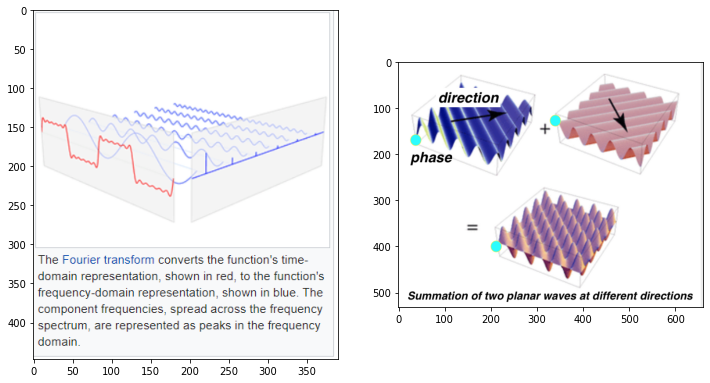

In [10]:
img_plot("Fourier transform.png", "directions.png", ncols=2, figsize=(12,12))

# K space

K space: represents Fourier transform of a *spatial* function (i.e. original fn has axis units of cm, so axis units of FT is 1/cm = wavenumber $k$).

Each k-space location ($kx, ky) =  (\omega,\theta)$ in polar coordinates in a k-space image defines a specific sinusoid wave (called stripe pattern).

In terms of $(\omega,\theta)$:
- $\theta$ specifies the stripe's direction
- $\omega$ specifies the stripe's width (sinusoid frequency)
  - Center: 
    - lower freq
    - wider stripes
    - patterns that change slowly across space
    - gross features
  - Periphery: 
    - higher freq
    - narrower stripes
    - patterns that change a lot across space
    - finer details like edges

The complex number $c =  Ae^{i\phi}$ at each $k$-space location $(kx,ky)$ represents the sinusoid's  
1. amplitude/intensity $A$ (how strong is the stripe signal)
2. phase (where to start in the infinite stripe pattern/sine wave).

Source: Mt Sinai talk, Harvey Mudd



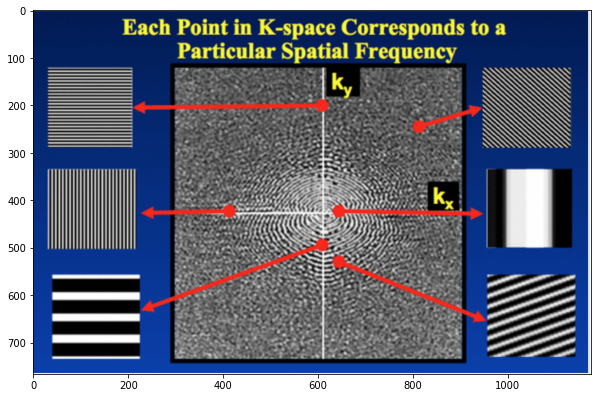

In [12]:
img_plot("kspace_point.png", figsize=(10,10))

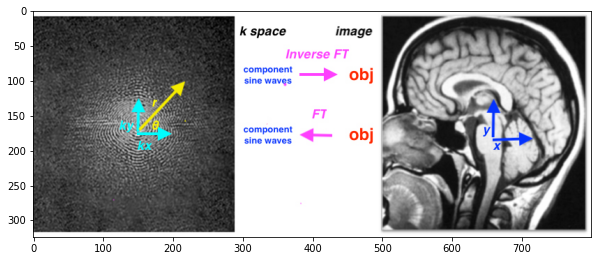

In [11]:
img_plot("kspace_to_image.jpg", figsize=(10,10)) # I edited a google image photo

# MR to K space


# Producing signal 
Protons in the magnetic field

- are hit with RF pulse at resonance freq 

- protons absorb energy

- protons enter higher-energy state (more antiparallel spin & synchronized precession) 
- net magnetization vector M (precessions do not cancel out)

- proton relaxes by emitting energy back in the form of a radio wave after the RF pulse ends

- the surrounding magnetic coils record the "echo," which is the sum of all the protons' emitted radio waves

## Localization

By default, all protons have the same resonance freq and so emit the same radio wave. How can we create a frequency signal that corresponds to spatial location in a xy slice?

### x-axis localization: frequency encoding

Apply a small magnetic field gradient in the x-axis direction so that

  - protons at different points in the x-axis are in diff magnetic field
  - have different precession resonance frequency (Larmor $w \propto B$)
  - have relaxtion radio wave w/different phase & freq

Then the "echo" is composed of waves of different frequency, which FT can isolate. 
  - The echo is analog, we sample it at discrete time points to digitize it. We cannot accurately measure frequencies that are more than half the sampling frequency (Nyquist limit).

To disinguish radio waves emitted from protons in different locations, we change the resonance freq of protons to correspond to their spacial location.
- Specifically, we add small magnetic field gradient in the X,Y,Z directions so that
    - protons in each voxel are in different magnetic field
    - have different precession resonance frequency (Larmor $w \propto B$)
    - have relaxtion radio wave w/different phase & freq

### x-axis localizatoin: frequency encoding

# Phase & Frequency encoding


The pixel value records the stripe pattern's intensity and shift = wave's amplitude and direction.

Frequency encoding: given an echo signal S = A + B we can determine the intensity of stripe patterns in the same direction.

amplitude of each frequency.

Phase encoding: by observing how shifting the phase affects amplitude, we can determine the phase shift of each component wave of a given frequency. 


- to isolate the amplitude & phase of each component sinusoidal wave, we do frequency & phase encoding. 
  - frequency encoding: for each component wave with frequency $w$ we can get its amplitude and average phase shift. However to get its actual phase we need to 
  - phase encoding: when 
Source: High School physics explained, MRI questions & answers, fMRI blog

Img Source = MI Questions & Answers

In [0]:
img_plot("2d.png") # from wiki

NameError: ignored

# K space to Image

Image source = google iamges search for k space image

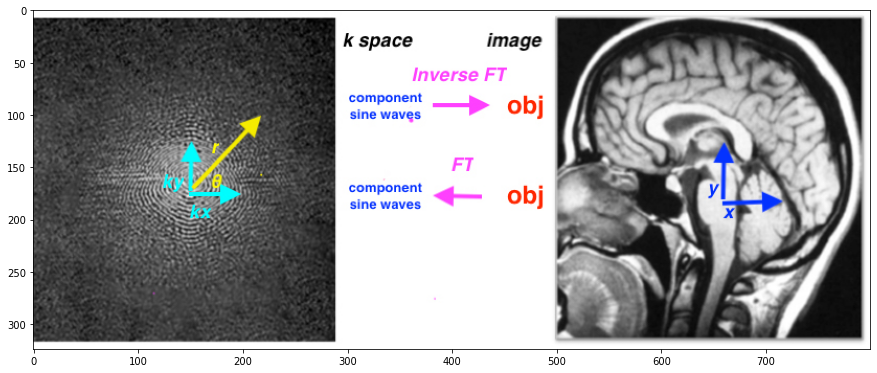

In [0]:
img_plot("kspace_to_image.jpg", figsize=(15,15)) # I edited a google image photo


Each pixel/voxel location in a K space image corresponds to specific stripe pattern/sinusoid wave.

Location in terms of $(r,\theta)$:
- $\theta$ specifies the stripe's rotation (sinusoid frequency - did I understand this correctly?)
- $r$ specifies the stripe's width (sinusoid amplitude)
  - Center pixels: represent wider stripe pattern (higher amplitude sine waves), capture gross features
  - Periphery pixels: represent narrower stripe pattern (lower amplitude, higher freq), capture finer details, e.g. edges

Each pixel (i.e. stripe pattern/sine wave) has 2 channels, 
1. intensity (how strong is the stripe signal)
2. phase (where to start in the infinite stripe pattern/sine wave).

Source: Mt Sinai talk


# MR to K space - Phase & Frequency Encoding: 

MR converts spatial information into k-space wave signals. Specifically RF gradient pulses step through the phase & frequency axes $(kx,ky)$ of k-space:

- Step through discerete phase values $ky$ by applying phase gradient pulse.
- At each $ky$ value, apply $kx$ gradient pulse. This results in an echo being recording over time window ET. 
- The echo is perceived as a sum of component sine waves. Each $(kx, ky) = (r,\theta)$ pixel location corresponds to a specific (amplitude, frequency) sine wave. For each component sine wave we record it's intensity & phase at the corresponding (kx,ky) location. (Did I understand this correctly?)

Note: 
- sampling an additional ky value increases MRI time by TR because we need to send out a new pulse and wait for the echo, but
- increasing the number of kx values does not increase MRI time because we are only increasing the number of sine waves in our echo analysis (Did I understand this correctly?)


Img sources = (Lecture at Albert Einstein, Mt Sinai talk)

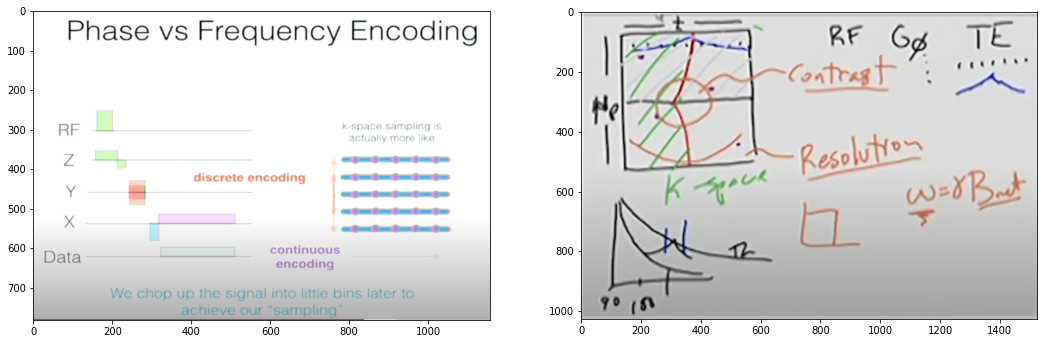

In [0]:
# img sources = (Lecture at Albert Einstein, Mt Sinai talk)
img_plot("discrete_vs_cont.png", "einstein.png", ncols=2, figsize = (18,18))



## Encoding Parameters
1. Resolution = how fine stripe patterns are 

 = farther out from origin 
 
 = furthest extent of k-space
 
 = largest magnitude of (kx,ky) = (freq, phase) values


2. Field of View = how many pixles in reconstructed image 

 = "more measurements" (no. of equations = no. of unkowns)

 = denser k-space sampling (sample more values of ky and kx within the given range of kx,ky values). Note: since we can sample as densely as we want in kx without time penalty, can have arbitrarily large FOV in x direction. 


3. Bandwidth = how frequently to sample time points in the echo response signal (units of kHz or normalized by Hz/stripe). 

 - Changing bandwidth (how fast we sample kx values) while holding constant image resolution (range of kx/ky values) and FOV (density i.e. step size of kx/ky values) results in faster output -- but also in higher levels of noise relative to signal.  

 Sources: Mt Sinai Talk, fMRI blog post

# MRI -> k space vs. Regular Image -> k space:

Both are sparse: only pixels that represent component sine waves are non-zero, so most pixel values in kspace are zero.

Both have pixel/stripe activations clustered in the center than in the periphery, but for different reasons: 

- MRI k space images: "Near to the center of k-space the signal is high because the amount of phase applied by the imaging gradients to the sample magnetization is low; the degree of signal cancellation is low."

- "The image of the Hurricane contains more broad areas of relatively uniform intensity - clouds in the sky, the grass, large blobs of camouflage painted on the wings and fuselage, etc. - than it does edges and other fine details. And since we now know that edges live in peripheral (high) k-space regions whereas spatially broad features live towards the center of k-space, we can consider the k-space plot as a kind of "spatial content map." There is simply more image content to map that changes slowly with distance than there is content that changes rapidly with distance (i.e. detail)." 

Source: fMRI blog part 15

Question: Is MRI k space data actually different from regular image in k space data? Did I understand correctly that it isn't?

MR k-space images $(kx,ky$) axes correspond to freq (1/cm) and phase (radians?). However, since k-space images can be converted to regular images via FT transform, and regular images are in units of cm by cm, this means that the original k-space image is also in reciprocal space of 1/cm by 1/cm (since FT transforms spaces into reciprocal spaces). Indeed, isn't the whole point of MR and gradient coils that steps in units of frequency/phase are exactly representing steps in image space? So if MR k space axes can be interpreted in terms of 1/cm, then don't pixel activations in the center just mean that the image represented in kspace has more content that changes slowly with distance than content that changes rapidly with distance?

# Questions 

1.-5. Cntrl+F "Did I understand this correctly."

#fin

In [0]:
!git status        # Check statuses of changed files
!git add --all     # Add/track files

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   notes/01_notes_FastMRI.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [0]:
!git commit -am "msg"    # Commit msg
!git push origin master # Push changes to Github repo

[master 5c6f14d] msg
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notes/01_notes_FastMRI.ipynb (90%)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 825 bytes | 275.00 KiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: This repository moved. Please use the new location:
remote:   https://github.com/RGologorsky/fastmri.git
To https://github.com/rgologorsky/fastmri
   3068245..5c6f14d  master -> master


In [0]:
# !rm .git/index.lock